# Readme
* Predict car prices
* Dataset src: imports-85 (https://archive.ics.uci.edu/ml/datasets/automobile)
* Uses k-fold cross validation for evaluating

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import SCORERS

# Get normalized data


In [10]:
normalized_cars = pd.read_csv('../data/imports-85d-dataquest.data')
target_column = 'price'

normalized_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Check data

In [24]:
# no nulls
assert normalized_cars.isnull().sum().sum() == 0

# check that all columns except target column go between 0 and 1
assert normalized_cars.drop(target_column, axis=1).describe().loc['min', :].sum() == 0


assert normalized_cars.drop(target_column, axis=1).describe().loc['max', :].unique().sum() == 1

# Perform k-fold cross validation

2. Try 5 and 10 folds

## Technical steps

1. Init the knn-regrross
2. Init KFold-class
2. cross_val_score to evalute using KFold and mse

# Functions

In [89]:
def get_errors_cross_val(data, features, number_folds=5, number_neighbors=2):
    error_df = pd.DataFrame()
    
    kfolds = KFold(n_splits=number_folds, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors=number_neighbors)
    
    neg_mse = cross_val_score(
        model
        , data[features]
        , data[target_column]
        , scoring='neg_mean_squared_error'
        , cv=kfolds
    )
    
    rmse_all = np.sqrt(np.abs(neg_mse))
    
    error_df.loc[0, 'rmse_mean'] = np.mean(rmse_all)
    error_df.loc[0, 'rmse_std'] = np.std(rmse_all)
    error_df.loc[0, 'features'] = '##'.join(features)
    error_df.loc[0, 'number_folds'] = number_folds
    error_df.loc[0, 'number_neighbors'] = number_neighbors
    
    return error_df

# Use the best performing model from here: predicting_car_prices.ipynb

In [142]:
feature_set = [
    ['engine-size', 'horsepower']
    , ['engine-size', 'horsepower', 'width']
    , ['engine-size', 'horsepower', 'width', 'curb-weight']
    , ['engine-size', 'horsepower', 'width','curb-weight', 'highway-mpg']
    , ['engine-size', 'horsepower', 'width','curb-weight', 'highway-mpg', 'length']
    
]
# for _ in normalized_cars.drop(target_column, axis=1).columns.tolist():
    # feature_set.append([_])

errors_all = pd.DataFrame()
neighbors = [x for x in range(1, 10)]


for features in feature_set:
    for k in neighbors:
        errors_features = get_errors_cross_val(
            normalized_cars
            , features
            , number_folds = normalized_cars.shape[0]
            , number_neighbors=k
        )
        errors_all = errors_all.append(errors_features)
        errors_all.reset_index(drop=True)

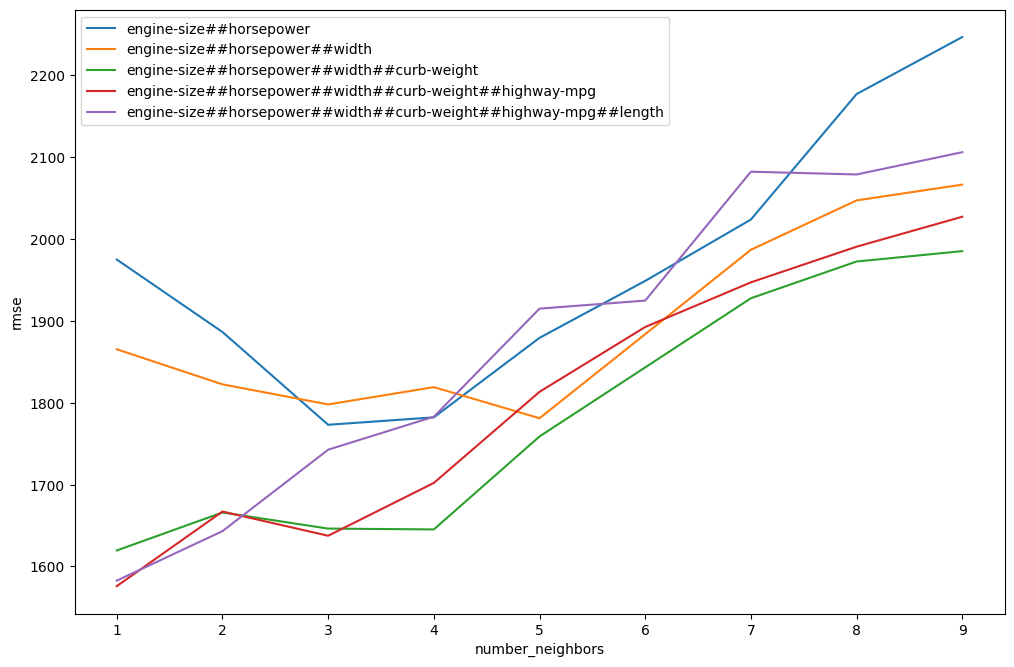

In [144]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

data_viz = errors_all.copy()
for _ in data_viz.features.unique().tolist():
    plt.plot(
        data_viz['number_neighbors'].unique().tolist()
        , data_viz.loc[data_viz['features']==_, 'rmse_mean']
        , label=_
    )
    plt.xlabel('number_neighbors')
    plt.ylabel('rmse')
plt.legend()

# H-Modell
* features = ['width', 'curb-weight']
* neighbors = 1-4 (eher 2-3)
* folds = [5, 10, n]

In [172]:
def get_errors(data, features, number_folds, number_neighbors):
    errors = pd.DataFrame()
    
    rmse_all = np.sqrt(np.abs(
        cross_val_score(
            KNeighborsRegressor(n_neighbors=number_neighbors)
            , data[features]
            , data[target_column]
            , scoring='neg_mean_squared_error'
            , cv = KFold(n_splits=number_folds, shuffle=True, random_state=1)
        )))
    
    errors.loc[0, 'rmse_mean'] = np.mean(rmse_all)
    errors.loc[0, 'rmse_std'] = np.std(rmse_all)
    errors.loc[0, 'number_folds'] = number_folds
    errors.loc[0, 'features'] = '##'.join(features)
    errors.loc[0, 'number_neighbors'] = number_neighbors
    
    return errors 

In [206]:
errors_all = pd.DataFrame()

# normalized_cars.shape[0] = n
folds_range = [5, 10, normalized_cars.shape[0]]
neighbors_range = [1, 2, 3, 4]

for number_neighbors in neighbors_range:
    
    for number_folds in folds_range:
        errors = get_errors(normalized_cars, ['width', 'curb-weight'], number_folds, number_neighbors)
        
        errors_all = errors_all.append(errors)
        errors_all.reset_index(drop=True, inplace=True)
        
errors_all = errors_all.sort_values(by=['number_folds','number_neighbors'], ascending=True)
errors_all.reset_index(drop=True, inplace=True)

In [207]:
errors_all

,rmse_mean,rmse_std,number_folds,features,number_neighbors
0,3826.563646,1128.590703,5.0,width##curb-weight,1.0
1,4112.156124,1270.483593,5.0,width##curb-weight,2.0
2,3795.081538,1036.305379,5.0,width##curb-weight,3.0
3,3785.461087,1109.707232,5.0,width##curb-weight,4.0
4,3755.657897,1689.376877,10.0,width##curb-weight,1.0
5,4007.491622,1716.334129,10.0,width##curb-weight,2.0
6,3898.568959,1495.961269,10.0,width##curb-weight,3.0
7,3891.481392,1448.894728,10.0,width##curb-weight,4.0
8,2128.353234,3456.894724,201.0,width##curb-weight,1.0
9,2365.131841,3651.342674,201.0,width##curb-weight,2.0


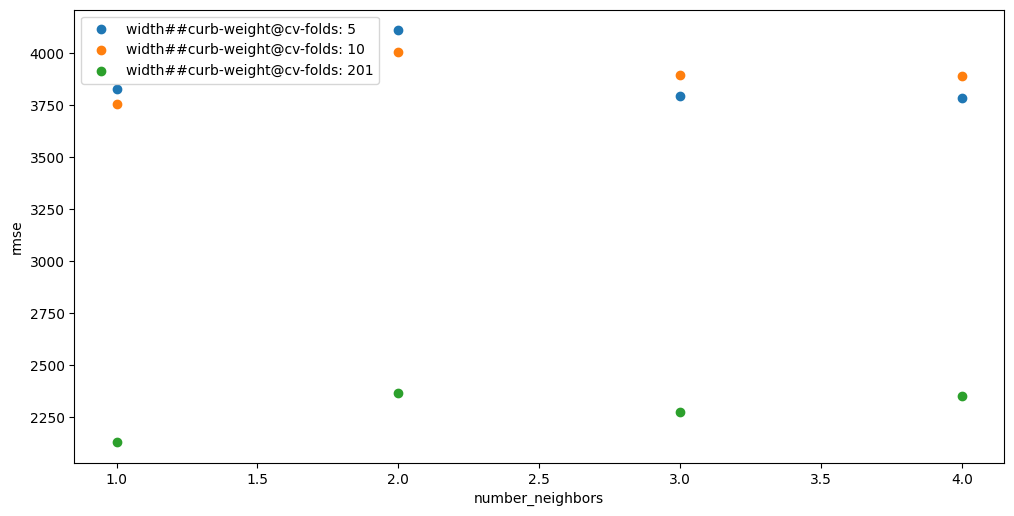

In [208]:
fig=plt.figure(figsize=(12, 6), dpi= 100, facecolor='w', edgecolor='k')

data_viz = errors_all.copy()
for number_folds in folds_range:
    for _ in data_viz.features.unique().tolist():
        plt.scatter(
            data_viz['number_neighbors'].unique().tolist()
            , data_viz.loc[(data_viz['features']==_) & (data_viz['number_folds']==number_folds), 'rmse_mean']
            , label='Features: '.format(', '.join(_.split('##')) + '@cv-folds: ' + str(number_folds))
        )
        plt.xlabel('number_neighbors')
        plt.ylabel('rmse')
    
plt.legend()

'width, curb-weight'